## 2D Ising Model

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


### Step 1: Initialize 2D grid of spins +/-1

In [2]:
def make_grid(nrows, ncols):
    grid = np.zeros((nrows, ncols), dtype = int)
    grid = np.random.choice([-1,1], size= (nrows,ncols) )
    return grid

def visualize_grid(grid, title):
    plt.imshow(grid, cmap= 'viridis', interpolation='nearest')
    plt.colorbar(ticks=[-1, 1], label='Spin value')
    plt.title(title)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()


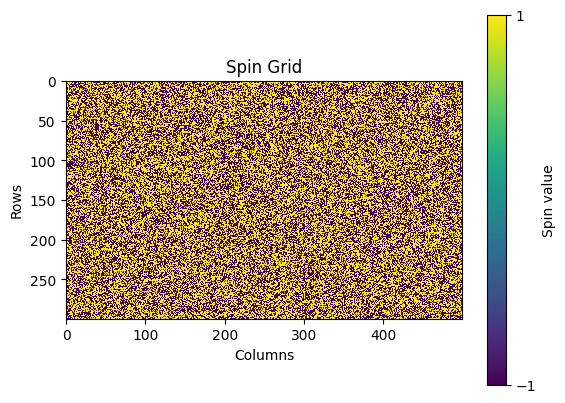

In [3]:
nrows = 300
ncols = 500
my_spins = make_grid(nrows,ncols)
visualize_grid(my_spins, 'Spin Grid')

Implement $ H=−J_{ij}∑_{⟨i,j⟩}​s_i​s_j​−μB_i∑_i​s_i​ $. $J_{ij}$ represents the interaction strength between spins $i$ and $j$. $J>0 => $ Ferromagnetic. $J<0 => $ antiferromagnetic. $J = 0 => $ non-interacting particles. (NOTE: this block is non-functional for now, because it's more computationally efficient to just compute the energy change for a spin flip of two nearest neighbors selected at random. This is why we use the Monte-Carlo simulation below.)

In [49]:
def calculate_ising_energy(grid, J, B_ext=0):
    """
    Calculates the total energy (Hamiltonian) of the 2D Ising model grid
    using a vectorized approach, which is much more efficient.
    
    The Hamiltonian is given by $H = - \sum_{\langle i, j \rangle} J_{ij} s_i s_j - B_{\text{ext}} \sum_i s_i$,
    where $J_{ij}$ is the exchange coupling constant between spins $i$ and $j$,
    and $B_{\text{ext}}$ is the external magnetic field.

    Args:
        grid (numpy.ndarray): The 2D spin grid.
        J (numpy.ndarray): A 2D array of the same dimensions as the grid,
                           containing the exchange coupling constants.
        B_ext (float): The external magnetic field strength. Defaults to 0.

    Returns:
        float: The total energy of the system.
    """
    # Calculate horizontal interactions using array shifting and the J array
    horizontal_interactions = grid * np.roll(grid, shift=1, axis=1) * J
    
    # Calculate vertical interactions using array shifting and the J array
    vertical_interactions = grid * np.roll(grid, shift=1, axis=0) * J
    
    # Calculate the total energy from the nearest-neighbor interactions
    nearest_neighbor_energy = - (np.sum(horizontal_interactions) + np.sum(vertical_interactions))
    
    # Calculate the energy from the external magnetic field
    external_field_energy = -B_ext * np.sum(grid)
    
    # Total energy is the sum of both components
    total_energy = nearest_neighbor_energy + external_field_energy
    
    return total_energy





<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8q/3ngjlxvn1ds0ggzhlfz2f3gh0000gn/T/ipykernel_92654/1010887752.py:6: SyntaxWarning: invalid escape sequence '\s'
  The Hamiltonian is given by $H = - \sum_{\langle i, j \rangle} J_{ij} s_i s_j - B_{\text{ext}} \sum_i s_i$,


## Monte Carlo Algorithm:
Initialization: Start with a system in some initial state. This could be a random configuration (like our spin grid) or a specific, ordered one.

Main Loop: Repeat the following steps a large number of times: 

a.  Select a component: Randomly choose a single element of your system to change (here, a single spin on the grid).

b.  Propose a change: Propose a new state for that element (here, flipping the spin from +1 to -1).

c.  Calculate energy change: Compute the change in energy ($\Delta$E) that would result from this change.

d.  Apply acceptance rule: Decide whether to accept or reject the change based on a rule that depends on $\Delta$E and the system's temperature. The Metropolis-Hastings algorithm is the most common rule. This algorithm uses the Boltzmann distribution $ Z = e^{-\Beta H(\sigma)}/Z_{\Beta} $, where $Z_{\Beta}$ is a normalization constant-- $Z_{\Beta} = \Sigma_{\sigma} e^{-\Beta H(\sigma)}$

e.  Update: If the change is accepted according to the acceptance rule, update the system's state.

In [50]:
def calculate_delta_energy(grid, r, c, J, B_ext=0):
    """
    Calculates the change in energy if a single spin at (r, c) is flipped.
    This is much more efficient than recalculating the entire grid energy.
    
    Args:
        grid (numpy.ndarray): The 2D spin grid.
        r (int): The row index of the spin to be flipped.
        c (int): The column index of the spin to be flipped.
        J (float): The exchange coupling constant.
        B_ext (float): The external magnetic field strength. Defaults to 0.
        
    Returns:
        float: The change in energy, $\Delta E$.
    """
    rows, cols = grid.shape
    
    # Use modulo to handle periodic boundary conditions
    neighbors_sum = (grid[(r + 1) % rows, c] +
                     grid[(r - 1) % rows, c] +
                     grid[r, (c + 1) % cols] +
                     grid[r, (c - 1) % cols])
                     
    # Calculate the change in energy if the spin at (r, c) were to flip
    delta_E = 2 * J * grid[r, c] * neighbors_sum + 2 * B_ext * grid[r, c]
    
    return delta_E

def update_grid(grid, num_steps, temperature, J, B_ext=0):
    """
    Performs a Monte Carlo simulation using the Metropolis-Hastings algorithm.
    
    Args:
        grid (numpy.ndarray): The 2D spin grid.
        num_steps (int): The number of Monte Carlo steps (spin flip attempts).
        temperature (float): The temperature of the system.
        J (float): The exchange coupling constant.
        B_ext (float): The external magnetic field strength. Defaults to 0.

    Returns:
        numpy.ndarray: The final spin grid after the simulation.
    """
    rows, cols = grid.shape
    
    # Use a Boltzmann constant for realism, but it's often set to 1 for simplicity
    kB = 1
    
    for _ in range(num_steps):
        # Pick a random spin to try and flip
        r = np.random.randint(0, rows)
        c = np.random.randint(0, cols)
        
        # Calculate the energy change for this potential flip
        delta_E = calculate_delta_energy(grid, r, c, J, B_ext)
        
        # Metropolis-Hastings acceptance rule
        if delta_E <= 0:
            # If energy decreases or stays the same, accept the flip
            grid[r, c] *= -1
        else:
            # If energy increases, accept the flip with a certain probability
            # The probability is given by the Boltzmann factor
            if np.random.rand() < np.exp(-delta_E / (kB * temperature)):
                grid[r, c] *= -1
                
    return grid


<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/var/folders/8q/3ngjlxvn1ds0ggzhlfz2f3gh0000gn/T/ipykernel_92654/589026777.py:14: SyntaxWarning: invalid escape sequence '\D'
  float: The change in energy, $\Delta E$.


In [51]:
def animate_simulation(i, img, grid, num_steps_per_frame, temperature, J, B_ext):
    """
    The main animation function that updates the plot for each frame.
    
    Args:
        i (int): The frame number (automatically passed by FuncAnimation).
        img (matplotlib.image.AxesImage): The image object to update.
        grid (numpy.ndarray): The 2D spin grid.
        num_steps_per_frame (int): The number of simulation steps to run per frame.
        temperature (float): The temperature of the system.
        J (float): The exchange coupling constant.
        B_ext (float): The external magnetic field strength. Defaults to 0.
        
    Returns:
        list: A list of artists to be updated.
    """
    # Perform a few simulation steps to update the grid
    update_grid(grid, num_steps_per_frame, temperature, J, B_ext)
    
    # Update the image data
    img.set_data(grid)
    
    # Print current energy to console for monitoring
    current_energy = calculate_ising_energy(grid, J=J, B_ext=B_ext)
    print(f"Frame {i+1}: Energy = {current_energy:.2f}")

    return [img]

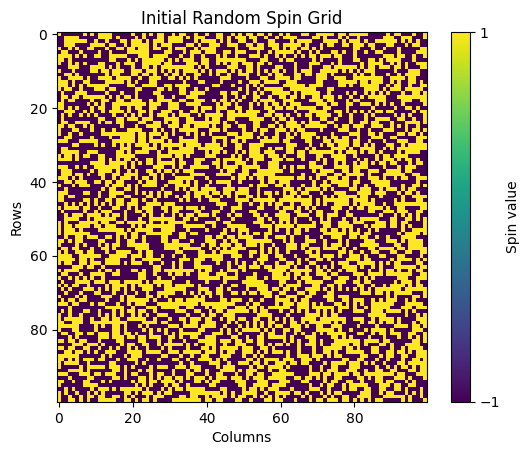

MovieWriter imagemagick unavailable; using Pillow instead.


Initial energy: -76.0
Saving animation toising_simulation_at_1.0K.gif...
Frame 1: Energy = -1412.00
Frame 1: Energy = -2576.00
Frame 2: Energy = -3508.00
Frame 3: Energy = -4332.00
Frame 4: Energy = -5124.00
Frame 5: Energy = -5728.00
Frame 6: Energy = -6404.00
Frame 7: Energy = -6968.00
Frame 8: Energy = -7372.00
Frame 9: Energy = -7772.00
Frame 10: Energy = -8112.00
Frame 11: Energy = -8484.00
Frame 12: Energy = -8824.00
Frame 13: Energy = -9144.00
Frame 14: Energy = -9476.00
Frame 15: Energy = -9740.00
Frame 16: Energy = -10044.00
Frame 17: Energy = -10324.00
Frame 18: Energy = -10584.00
Frame 19: Energy = -10896.00
Frame 20: Energy = -11120.00
Frame 21: Energy = -11340.00
Frame 22: Energy = -11528.00
Frame 23: Energy = -11668.00
Frame 24: Energy = -11828.00
Frame 25: Energy = -12012.00
Frame 26: Energy = -12252.00
Frame 27: Energy = -12376.00
Frame 28: Energy = -12544.00
Frame 29: Energy = -12724.00
Frame 30: Energy = -12812.00
Frame 31: Energy = -12932.00
Frame 32: Energy = -13036

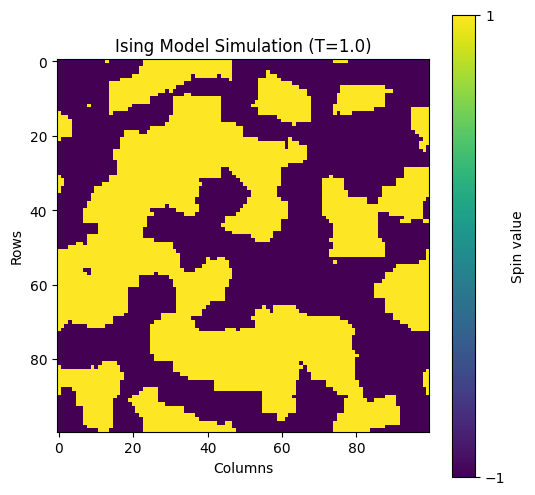

In [ ]:

# Define the dimensions of the grid
num_rows = 100
num_cols = 100

# Define Hamiltonian parameters for a ferromagnetic material
J_coupling = 1.0
B_field = 0.0

# Define simulation parameters
temperature = 1.0  # A low temperature to see ordering
steps_per_frame = 1000 #A large number of steps per frame to see more dramatic changes

# Create the initial spin grid
initial_spin_grid = make_grid(num_rows, num_cols)
visualize_grid(initial_spin_grid, 'Initial Random Spin Grid')

print(f"Initial energy: {calculate_ising_energy(initial_spin_grid, J=J_coupling, B_ext=B_field)}")

# Set up the figure and axis for the animation

fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(initial_spin_grid, cmap='viridis', interpolation='nearest', animated=True)
ax.set_title(f'Ising Model Simulation (T={temperature})')
ax.set_xlabel('Columns')
ax.set_ylabel('Rows')
plt.colorbar(img, ticks=[-1, 1], label='Spin value')

# Run the Monte Carlo simulation

ani = animation.FuncAnimation(
        fig,
        animate_simulation,
        fargs=(img, initial_spin_grid, steps_per_frame, temperature, J_coupling, B_field),
        frames=200,  # Number of frames in the animation
        interval=50  # Interval between frames in milliseconds
    )

print("Saving animation to" + 'ising_simulation_at_' + str(temperature) + 'K.gif' + "...")
ani.save('ising_simulation_at_' + str(temperature) + 'K.gif', writer='imagemagick', fps=20)
print("Animation saved successfully!")

